<a href="https://colab.research.google.com/github/shanikairoshi/QFL-with-DUN/blob/main/QFl_DeepUnfoldingWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
#Install required Dependencies
!pip install --upgrade seaborn
!pip install --upgrade scikit-learn
!pip install --upgrade matplotlib
!pip install --upgrade pandas
!pip install --upgrade qiskit
!pip install qiskit_machine_learning

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from qiskit import *
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit_machine_learning.optimizers import SPSA
from qiskit import BasicAer, execute
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import COBYLA
import time

clear_output()

01. First Module for Weight Calculation on Classical NN based Deep unfolding.

In [ ]:
#%%
#%% this is for sgd optmizer to train unfolding
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#Data loading step and settings
#%% Parameters
T = 10                  # number of rounds for FL
M = 10                 # number of learning iterations
Es = [2, 1, 1, 1, 1]    # number of epochs
batch_size = 50         # mini-batch size
lr_du = 0.001           # learning rate for proposed preprocess
mu = 0.01               # learning rate for ClientUpdate
num_feature = 128       # dimension of hidden layers
#q = 1                   # parameter for DR-FedAvg

# Fixed parameters
K = 5                   # number of clients
datalocation = '/content/drive/MyDrive/Colab Notebooks/mnist/5clients_env3_4/'                     # data for env3
N = sum([1713, 1713, 1713, 1713, 1716])                     # number of all training data for env3

print("Set parameters", flush=True)

#%% Global Data Load
root = '.'
download = True
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
test_set = datasets.MNIST(root=root, train=False, transform=trans, download=download)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

print("Download done", flush=True)

#%% Local Data setting
datasizes_test = []
for i in range(K):
    datasizes_test.append(int(round(len(test_set)/K)))
test_sets = torch.utils.data.random_split(dataset=test_set, lengths=datasizes_test, generator=torch.Generator().manual_seed(42))

test_loaders = []
train_datasets = []

for node in range (K):
    localtraindata = np.load(datalocation+'train/'+str(node)+'.npz', allow_pickle=True)     # training data load
    localtraindata = np.atleast_1d(localtraindata['data'])
    inputs = localtraindata[0]['x']
    targets = localtraindata[0]['y']
    tensor_X = torch.stack([torch.from_numpy(i) for i in inputs])
    tensor_y = torch.stack([torch.from_numpy(np.array(i)) for i in targets])
    train_datasets.append(torch.utils.data.TensorDataset(tensor_X,tensor_y))
    test_loaders.append(torch.utils.data.DataLoader(dataset=test_sets[node], batch_size=batch_size, shuffle=False))
pk = [len(train_datasets[node])/N for node in range(K)]

print("Set local data", flush=True)

#%% Definition of Initial Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, num_feature)
        self.l2 = nn.Linear(num_feature, num_feature)
        self.l3 = nn.Linear(num_feature, 10)
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.l3(x)
        return F.log_softmax(x, dim=1)

#%% Definition of Unfolded FL
class TrainDUW(nn.Module):
    def __init__(self) -> None:
        super(TrainDUW, self).__init__()
        self.thetak = nn.ParameterList([nn.Parameter(torch.ones(T)*np.sqrt(len(train_datasets[i])/N)) for i in range(K)])
        # initial value: N_k/N
    def network(self, W1, b1, W2, b2, W3, b3, x):
        x = torch.relu(torch.matmul(x,W1.T)+b1.T)
        x = torch.relu(torch.matmul(x,W2.T)+b2.T)
        x = F.log_softmax(torch.matmul(x,W3.T)+b3.T, dim=1)
        return x
    def forward(self, aveW1, aveb1, aveW2, aveb2, aveW3, aveb3):
        outputlists = []
        targetlists = []
        for itr in range(T+1):
            tmploss = 0.
            outputlist = []
            targetlist = []
            if not itr == T:
                sumweights = sum([self.thetak[x][itr]**2 for x in range(K)])
            for node in range(K):
                weight1, bias1, weight2, bias2, weight3, bias3 = aveW1, aveb1, aveW2, aveb2, aveW3, aveb3
                weight1.requires_grad_(True)
                bias1.requires_grad_(True)
                weight2.requires_grad_(True)
                bias2.requires_grad_(True)
                weight3.requires_grad_(True)
                bias3.requires_grad_(True)
                train_loader_node = torch.utils.data.DataLoader(dataset=train_datasets[node], batch_size=batch_size, shuffle=True)
                outputvalues = []
                targetvalues = []
                for ep in range(Es[node]):
                    for (input, target) in train_loader_node:
                        input = input.view(-1, 28*28)
                        output = self.network(weight1,bias1,weight2,bias2,weight3,bias3,input)
                        outputvalues.append(output)
                        targetvalues.append(target)
                        if not itr == T:
                            loss = F.nll_loss(output, target)
                            tmploss += loss.item()
                            w1grad = torch.autograd.grad(loss,weight1,retain_graph=True)
                            b1grad = torch.autograd.grad(loss,bias1,retain_graph=True)
                            w2grad = torch.autograd.grad(loss,weight2,retain_graph=True)
                            b2grad = torch.autograd.grad(loss,bias2,retain_graph=True)
                            w3grad = torch.autograd.grad(loss,weight3,retain_graph=True)
                            b3grad = torch.autograd.grad(loss,bias3,retain_graph=True)
                            weight1 = weight1 - mu * w1grad[0].detach()
                            bias1 = bias1 - mu * b1grad[0].detach()
                            weight2 = weight2 - mu * w2grad[0].detach()
                            bias2 = bias2 - mu * b2grad[0].detach()
                            weight3 = weight3 - mu * w3grad[0].detach()
                            bias3 = bias3 - mu * b3grad[0].detach()
                if not itr == T:
                    if node == 0:
                        weight0 = self.thetak[node][itr]**2 / sumweights
                        W1, b1, W2, b2, W3, b3 = weight1*weight0, bias1*weight0, weight2*weight0, bias2*weight0, weight3*weight0, bias3*weight0
                    else:
                        weightnode = self.thetak[node][itr]**2 / sumweights
                        W1, b1, W2, b2, W3, b3 = W1 + weight1*weightnode, b1 + bias1*weightnode, W2 + weight2*weightnode, b2 + bias2*weightnode, W3 + weight3*weightnode, b3 + bias3*weightnode
                outputlist.append(outputvalues)
                targetlist.append(targetvalues)
                if itr == T:
                    print(self.thetak[node]**2/sumweights, flush=True)
            aveW1, aveb1, aveW2, aveb2, aveW3, aveb3 = W1, b1, W2, b2, W3, b3
            outputlists.append(outputlist)
            targetlists.append(targetlist)
        return outputlists, targetlists

print("Network defined", flush=True)


#%% Functions
def model_initialize(initmodel):
    models = []
    for i in range(K):
        models.append(Net())
    for node in range(K):
        models[node].l1.weight.data = initmodel.l1.weight.data.clone()
        models[node].l1.bias.data = initmodel.l1.bias.data.clone()
        models[node].l2.weight.data = initmodel.l2.weight.data.clone()
        models[node].l2.bias.data = initmodel.l2.bias.data.clone()
        models[node].l3.weight.data = initmodel.l3.weight.data.clone()
        models[node].l3.bias.data = initmodel.l3.bias.data.clone()
    return models

#%% Model Sharing
model = Net()       # common initial model
models = model_initialize(model)        # models for proposed DUN

# initial model parameters
aveW1 = model.l1.weight.data.clone().requires_grad_(False)
aveb1 = model.l1.bias.data.clone().requires_grad_(False)
aveW2 = model.l2.weight.data.clone().requires_grad_(False)
aveb2 = model.l2.bias.data.clone().requires_grad_(False)
aveW3 = model.l3.weight.data.clone().requires_grad_(False)
aveb3 = model.l3.bias.data.clone().requires_grad_(False)

print("Model sharing done", flush=True)


#%%
import time

# Start the timer
start_time = time.time()
modelDUR = TrainDUW()
learnedweightsR = torch.zeros(M+1, T, K)
sumweightsR = torch.zeros(T)
for itr in range(T):
    sumweightsR[itr] = sum([modelDUR.thetak[x][itr].item()**2 for x in range(K)])
for node in range(K):
    learnedweightsR[0,:,node] = modelDUR.thetak[node].detach()**2 / sumweightsR
#optimizerDUR = optim.Adam(modelDUR.parameters(), lr=lr_du)
optimizerDUR = optim.SGD(modelDUR.parameters(), lr=lr_du, weight_decay=0.001)

#%%,weight_decay=0.01
# Training of Deep Unfolding-based Weights
outerloss = []
i = 0
for loop in range(M):
    i = i+1
    print(i, flush=True)
    optimizerDUR.zero_grad()
    outputlists, targetlists = modelDUR(aveW1, aveb1, aveW2, aveb2, aveW3, aveb3)
    loss = 0
    for j in range(T+1):
        for node in range(K):
            num_localdata = len(outputlists[j][node])
            for l in range(num_localdata):
                loss += F.nll_loss(outputlists[j][node][l], targetlists[j][node][l])
    loss.backward()
    optimizerDUR.step()
    outerloss.append(loss.item())
    sumweightsR = torch.zeros(T)
    for itr in range(T):
        sumweightsR[itr] = sum([modelDUR.thetak[x][itr].item()**2 for x in range(K)])
    for node in range(K):
        learnedweightsR[i,:,node] = modelDUR.thetak[node].detach()**2 / sumweightsR
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print("Execution time:", elapsed_time, "seconds")
print("Deep unfolding done", flush=True)
# print ('outerloss = ', outerloss, flush=True)


#Plot weights for each client in each round
import matplotlib.pyplot as plt
import numpy as np
import csv as csv
# Learned thetak Save
results = []
for node in range(K):
    labelname = 'learned theta ' + str(node)
    data = [i for i in learnedweightsR[M, :, node]]
    results.append([labelname] + data)

# Save results to a CSV file
filename = "learned_thetakREnv2_propose.csv"
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
    writer.writerows(results)  # Write data rows

print(f"Results saved to {filename}")


#Plot this same as other figure.
import matplotlib.pyplot as plt
import numpy as np

K = 5
colors = ['red', 'blue', 'green', 'orange', 'purple']  # Specify the desired colors for each line
markers = ['o', 's', '^', 'v', 'D']  # Specify the desired markers for each line

# Learned thetak
fig2 = plt.figure()
for node in range(K):
    labelname = 'learned theta ' + str(node)
    plt.plot([i for i in learnedweightsR[M, :, node]], label=labelname, linewidth=3, marker=markers[node], markersize=12, color=colors[node])
plt.legend(fontsize=18)
plt.xlabel("com_round t", fontsize=16)
plt.ylabel("learned theta", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
fig2.savefig("learned_thetak.png")


In [ ]:
# Set random seed
algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)

# Define the feature map and variational form
FEATURE_MAP = ZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# Combine feature map and variational form to create the circuit
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

#======================================
#Loading Data
image_size = 28 # width and length are equal
data_path= "/content/drive/MyDrive/Colab Notebooks/"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")


In [20]:

#Dimensionality Reduction
#Extracting features and labels from the dataset and truncating the dataset to 10,000 datapoints
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

# Using SVD to reduce dimensions to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

# Use t-SNE technique to reduce dimensions to 2
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

In [21]:
#Extracting and Normalizing Data

zero_datapoints_array = [] #an array of the data points containing value 0
one_datapoints_array = []# an array of the data points containing value 1
for i in range(10000):
    if train_data_labels[i] == 0:                   # extracting zeros
        zero_datapoints_array.append(train_data_features_reduced[i])

for i in range(10000):
    if train_data_labels[i] == 1:                   # extracting ones
        one_datapoints_array.append(train_data_features_reduced[i])

zero_datapoints_array = np.array(zero_datapoints_array)
one_datapoints_array = np.array(one_datapoints_array)

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n
zero_datapoints_normalized = normalize(zero_datapoints_array, 100, 1)
one_datapoints_normalized = normalize(one_datapoints_array, 100, 1)



In [22]:
#Split data into clients in federated setting
# Assuming you have the data defined as per your initial code
train_size = 200
test_size = 10
dp_size_zero = 5
dp_size_one = 5

zero_train = zero_datapoints_normalized[:train_size]
one_train = one_datapoints_normalized[:train_size]

zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

training_input = {'A': zero_train, 'B': one_train}
test_input = {'A': zero_test, 'B': one_test}

datapoints = []
dp_zero = zero_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_zero]
dp_one = one_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_one]
datapoints.append(np.concatenate((dp_zero, dp_one)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)

class_to_label = {'A': 0, 'B': 1}

# Split data for 5 clients
num_clients = 5
client_data = {f'Client_{i+1}': {'TRAIN_DATA': [], 'TRAIN_LABELS': [], 'TEST_DATA': [], 'TEST_LABELS': []} for i in range(num_clients)}

for i in range(num_clients):
    start_idx = i * (train_size // num_clients)
    end_idx = (i + 1) * (train_size // num_clients)

    client_data[f'Client_{i+1}']['TRAIN_DATA'] = np.concatenate((zero_train[start_idx:end_idx], one_train[start_idx:end_idx]))
    client_data[f'Client_{i+1}']['TRAIN_LABELS'] = np.array([class_to_label['A']] * (end_idx - start_idx) + [class_to_label['B']] * (end_idx - start_idx))

    start_idx = i * (test_size // num_clients)
    end_idx = (i + 1) * (test_size // num_clients)

    client_data[f'Client_{i+1}']['TEST_DATA'] = np.concatenate((zero_test[start_idx:end_idx], one_test[start_idx:end_idx]))
    client_data[f'Client_{i+1}']['TEST_LABELS'] = np.array([class_to_label['A']] * (end_idx - start_idx) + [class_to_label['B']] * (end_idx - start_idx))

# Print client data
for client, data in client_data.items():
    print(f'{client}:')
    print(data)
    print()

Client_1:
{'TRAIN_DATA': array([[1.7128973 , 0.69763577],
       [1.7548386 , 0.6635097 ],
       [1.5829053 , 0.6011364 ],
       [1.6286227 , 0.60453415],
       [1.7857454 , 0.7875675 ],
       [1.853204  , 0.824271  ],
       [1.7540939 , 0.67810833],
       [1.7745657 , 0.98342216],
       [1.5432764 , 0.7645431 ],
       [1.528223  , 0.7126163 ],
       [1.6001639 , 0.7452649 ],
       [1.795907  , 0.93081737],
       [1.6040237 , 0.74899626],
       [1.7896724 , 0.9918744 ],
       [1.8097465 , 0.71981466],
       [1.6741481 , 0.8785018 ],
       [1.7572708 , 0.6548944 ],
       [1.8401012 , 0.90903604],
       [1.8329911 , 0.78010976],
       [1.5565255 , 0.7727901 ],
       [1.603467  , 0.8276392 ],
       [1.8032928 , 0.85159564],
       [1.824754  , 0.90558416],
       [1.5976703 , 0.9176028 ],
       [1.5922863 , 0.9626111 ],
       [1.8168559 , 0.9437522 ],
       [1.5426507 , 0.91032326],
       [1.6223259 , 0.90492076],
       [1.7684219 , 0.97408706],
       [1.8138268 

In [23]:
from qiskit.circuit.library import ZFeatureMap, TwoLocal, RealAmplitudes

#Define Variational circuit
num_qubits = 2

# Define the feature map and variational form
FEATURE_MAP = ZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = RealAmplitudes(num_qubits, entanglement='full', reps=3)

# Combine feature map and variational form to create the circuit
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

class localOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

initial_point = np.random.random(VAR_FORM.num_parameters)

In [24]:
#Global optimizer log
class GlobalOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

global_optimizer_log = GlobalOptimizerLog()

# Initialize global model
global_model = VQC(
    feature_map=FEATURE_MAP,
    ansatz=VAR_FORM,
    loss='cross_entropy',
    optimizer=SPSA(callback=global_optimizer_log.update),
    initial_point=initial_point,
    quantum_instance=BasicAer.get_backend('qasm_simulator')
)

In [25]:
#Federated Training
from qiskit.algorithms.optimizers import SLSQP
#Local Training with Global Training
import warnings
warnings.filterwarnings("ignore")
# Training settings
num_rounds = 10
learning_rate = 0.001  # Adjust as needed

# Create a list of VQC instances, one for each client
clients = []
# Initialize an empty list to store client logs
client_logs = []
# Initialize an empty list to store client parameters
client_parameters = []
global_parameters=[]
global_cost=[]

# Array to store global cost
GlobalCostperRoundAll=[]

# Initialize global parameters
global_parameters = np.random.rand(VAR_FORM.num_parameters)  # Initialize with random values or any desired initial values
client_weights=learnedweightsR[node][-1]



In [26]:
client_weights

tensor([0.2271, 0.1922, 0.1924, 0.1911, 0.1972])

In [27]:
sum(client_weights)

tensor(1.)

In [29]:
#Weighted FL
aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters

# Federated training loop
for round_num in range(num_rounds):
    global_cost=[]
    client_logs=[]

    #Initialize aggregated parameters to global result of previous round

    # Train each client's data on their VQC models
    i=0
    i_max=num_clients
    for client_id, data in client_data.items():
       if i!=i_max+1:
        #print(client_id)
        train_data = data['TRAIN_DATA']
        train_labels = data['TRAIN_LABELS']
        test_data = data['TEST_DATA']
        test_labels = data['TEST_LABELS']
        #train_data, train_labels, test_data, test_labels= data

        # Set up the optimization

        Locallog = localOptimizerLog()
        optimizer = SPSA(maxiter=100, callback=Locallog.update)
        vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=Locallog.update),
          initial_point=global_parameters,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

        vqc.fit(train_data, train_labels)
        clients.append(vqc)
        client_logs.append(Locallog)
        #print(len(Locallog.parameters[-1])) #12 parameters for each client
        #print(client_weights[i])

        #Normalize these weights


        import tensorflow as tf
        print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")
        # Convert the NumPy array to a TensorFlow tensor
        parameters_tf = tf.convert_to_tensor(Locallog.parameters[-1], dtype=tf.float32)

        #weighted_aggregated_params_perclient=parameters_tf * client_weights[i]
        #print(f"Round {round_num}, Client {client_id}: parameters = {weighted_aggregated_params_perclient}")

        # Element-wise multiplication of parameters with client weight
        #weighted_params = parameters_tf * client_weights[i]

        # Aggregate the weighted parameters
        #aggregated_params += weighted_params
        #aggregated_params = [sum(value) for value in zip(weighted_aggregated_params_perclient)]
        #print(aggregated_params)

        # Update aggregated_params by adding the client's parameters element-wise
       # Update aggregated_params by adding the weighted client parameters element-wise
        weighted_parameters = parameters_tf * client_weights[i]
        aggregated_params += weighted_parameters
        i=i+1


    # Calculate the sum of weighted aggregated parameters
    aggregated_params /= sum(client_weights)

    global_parameters=aggregated_params
    print(f"Round {round_num},global: aggregated_parameters = {global_parameters}")
    # Update the global optimizer log with the aggregated parameters
    global_optimizer_log.parameters.append(global_parameters)
    global_model.fit(train_data, train_labels)
    global_cost = global_optimizer_log.costs
    print(f"Round {round_num},global cost: {global_cost}")


    # Save results to a CSV file

    # Create a list to store the last values of global_cost
    last_values = []
    filename = "Cost_DUNQFL.csv"

    # At the end of each round, save the last value of global_cost
    last_value = global_cost[-1]
    last_values.append(last_value)

with open(filename, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
  writer.writerow(["Last Value"])  # Write a header row
  for last_value in last_values:
    writer.writerow([last_value])


print(f"Results saved to {filename}")
    #global_parameters=global_optimizer_log.parameters[-1]
#print(global_parameters)
#Aggregate client parameters




Round 0, Client Client_1: parameters = [-0.06176627 -3.04276502  0.02283114 -0.44551033  2.97547128  2.00927399
 -0.08948449  1.61469196]
Round 0, Client Client_2: parameters = [ 4.77689887  0.15946166  0.15633985 -0.02572994  1.30584809 -0.48001873
 -3.26089315 -0.46622542]
Round 0, Client Client_3: parameters = [-6.22817919 -4.79445177 -0.69803355 -3.65030344  6.08246516  0.56124782
 -2.34327319 -7.81189947]
Round 0, Client Client_4: parameters = [ 0.73200869  3.02043374 -2.08215815 -1.83881683 -2.98560907  0.40958894
  2.93002562  6.27767972]
Round 0, Client Client_5: parameters = [ 0.31231813  3.74886507  3.66228108  2.94594041 -0.0150066  -1.25849814
 -0.40363598  1.19985479]
Round 0,global: aggregated_parameters = [-0.09264934 -0.2658478   0.22536469 -0.57869804  1.5231004   0.30201757
 -0.61736405  0.21077801]
Round 0,global cost: [2.005289579216138, 2.0000450131553116, 0.9766660972544878, 0.9705067870799027, 0.8630218662167699, 0.7479990043611611, 0.7438861230834076, 0.74536725

In [ ]:
        #each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
for client_id, log in enumerate(client_logs):
    plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}')
plt.plot(range(epoch), global_optimizer_log.costs[-100:], label="global", linewidth=2, marker='*')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QiskitDUN-QFL Cost Evolution for Optimization-Mnist Data')
plt.legend()
plt.show()

In [30]:
filename2="DUNcost_globallast Round.csv"
with open(filename2, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
  writer.writerow(["Last Value"])  # Write a header row
  for last_value in last_values:
    writer.writerow(global_optimizer_log.costs[-100:])


print(f"Results saved to {filename2}")

Results saved to DUNcost_globallast Round.csv


In [ ]:
#Weighted FL
aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters

# Federated training loop
for round_num in range(num_rounds):
    global_cost=[]
    client_logs=[]

    #Initialize aggregated parameters to global result of previous round

    # Train each client's data on their VQC models
    i=0
    i_max=num_clients
    for client_id, data in client_data.items():
       if i!=i_max+1:
        #print(client_id)
        train_data = data['TRAIN_DATA']
        train_labels = data['TRAIN_LABELS']
        test_data = data['TEST_DATA']
        test_labels = data['TEST_LABELS']
        #train_data, train_labels, test_data, test_labels= data

        # Set up the optimization

        Locallog = localOptimizerLog()
        optimizer = SPSA(maxiter=100, callback=Locallog.update)
        vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=Locallog.update),
          initial_point=global_parameters,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

        vqc.fit(train_data, train_labels)
        clients.append(vqc)
        client_logs.append(Locallog)
        #print(len(Locallog.parameters[-1])) #12 parameters for each client
        #print(client_weights[i])

        #Normalize these weights


        import tensorflow as tf
        print(f"Round {round_num}, Client {client_id}: parameters = {Locallog.parameters[-1]}")
        # Convert the NumPy array to a TensorFlow tensor
        parameters_tf = tf.convert_to_tensor(Locallog.parameters[-1], dtype=tf.float32)

        #weighted_aggregated_params_perclient=parameters_tf * client_weights[i]
        #print(f"Round {round_num}, Client {client_id}: parameters = {weighted_aggregated_params_perclient}")

        # Element-wise multiplication of parameters with client weight
        #weighted_params = parameters_tf * client_weights[i]

        # Aggregate the weighted parameters
        #aggregated_params += weighted_params
        #aggregated_params = [sum(value) for value in zip(weighted_aggregated_params_perclient)]
        #print(aggregated_params)

        # Update aggregated_params by adding the client's parameters element-wise
       # Update aggregated_params by adding the weighted client parameters element-wise
        weighted_parameters = parameters_tf * client_weights[i]
        aggregated_params += weighted_parameters
        i=i+1


    # Calculate the sum of weighted aggregated parameters
    aggregated_params /= sum(client_weights)

    global_parameters=aggregated_params
    print(f"Round {round_num},global: aggregated_parameters = {global_parameters}")
    # Update the global optimizer log with the aggregated parameters
    global_optimizer_log.parameters.append(global_parameters)
    global_model.fit(train_data, train_labels)
    global_cost = global_optimizer_log.costs
    print(f"Round {round_num},global cost: {global_cost}")


      # Save results to a CSV file

    # Create a list to store the last values of global_cost
    last_values = []
    filename = "Cost_DUNQFL.csv"

     # At the end of each round, save the last value of global_cost
    last_value = global_cost[-1]
    last_values.append(last_value)

with open(filename, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
  writer.writerow(["Last Value"])  # Write a header row
  for last_value in last_values:
    writer.writerow([last_value])


print(f"Results saved to {filename}")
    #global_parameters=global_optimizer_log.parameters[-1]
#print(global_parameters)
#Aggregate client parameters




In [ ]:
filename2="cost_globallast Round.csv"
with open(filename2, 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(["Label"] + [f"Data {i+1}" for i in range(len(data))])  # Write header row
  writer.writerow(["Last Value"])  # Write a header row
  for last_value in last_values:
    writer.writerow(global_optimizer_log.costs[-100:])


print(f"Results saved to {filename2}")

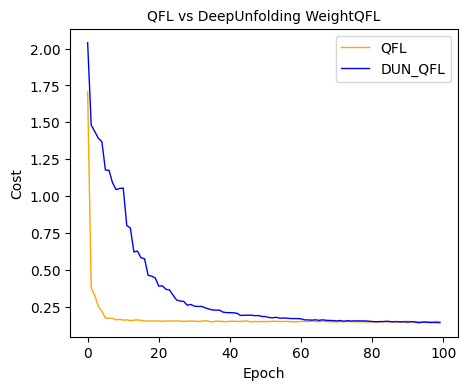

In [34]:
import csv
import matplotlib.pyplot as plt
# Read data from the CSV file and append it to the list
fileName1="/content/drive/MyDrive/Colab Notebooks/QFL/cost_globallast Round.csv"
qfl=[]
dunqfl=[]
try:
    with open(fileName1, mode='r', newline='') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Skip the header row if present
        for row in reader:
            # Assuming the CSV file has one column
            dunqfl.append((float(row[1])))
            qfl.append(float(row[0]))  # Convert to float if needed
except FileNotFoundError:
    print(f"The file '{fileName1}' was not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#each client cost variations over epochs for whole set code
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
# Plot cost for each client over rounds
epoch = 100
#for client_id, log in enumerate(client_logs):
    #plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}', linestyle='dashed')
plt.plot(range(epoch), qfl, label="QFL", linewidth=1,color='orange')#LR=0.01, maxiter=100
plt.plot(range(epoch), dunqfl, label="DUN_QFL", linewidth=1,color='blue')#LR=0.01, maxiter=100

plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('QFL vs DeepUnfolding WeightQFL', fontsize=10)
plt.legend()
plt.show()